# Data Analysis and Mining - PCA

## Objectives 
- Perform Principal Component Analysis.
- Perform Single Value Decomposition.

## Initialization

### Import libraries

In [319]:
import numpy as np
import pandas as pd
import seaborn as sns
import skfuzzy as fuzz

from matplotlib import pyplot as plt

%matplotlib inline
sns.set_style("darkgrid")

### Load data

Start by loading the entire dataset.

In [320]:
# Specify the path to the dataset CSV file
dataset_path = "../../Dataset/dataset.csv"

# Read the dataset into a pandas DataFrame
df = pd.read_csv(dataset_path)

df.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016
1,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,...,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1.0,2015
2,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,...,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3.0,2018
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,...,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3.0,2019
4,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,...,26.9,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1.0,2017


### Data cleaning

Then, we drop columns that we do not need. In addition, we add one more column which represents the percentage of win games, as it is one of the most interesting features.

In [321]:
# Drop columns 'TEAM', 'CONF', 'POSTSEASON', 'SEED'
df = df.drop(['TEAM', 'CONF', 'POSTSEASON', 'SEED'], axis=1)

Check the size of the dataset.

In [322]:
df.shape

(1757, 20)

We decided to analyze a subset of the whole dataset. Since our dataset is a collection of data which belongs to 5 different seasons, we filter the dataset by only keeping and analyzing the information related to one year.

In [323]:
# Filter by year, keep only data from selected year
df = df[df['YEAR'] == 2015].drop('YEAR', axis=1)

Check the size of the dataset.

In [324]:
df.shape

(351, 19)

In [325]:
df.head()

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB
1,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3
5,39,35,125.2,90.6,0.9764,56.6,46.5,16.3,18.6,35.8,30.2,39.8,23.9,55.9,46.3,38.7,31.4,66.4,10.7
10,36,27,109.4,87.4,0.9290,47.7,44.0,17.2,21.3,34.7,30.8,38.7,33.3,48.4,43.3,30.7,30.3,65.6,5.8
11,38,32,125.3,98.6,0.9401,58.3,47.9,14.5,17.3,27.9,32.2,36.7,24.1,58.2,47.4,39.0,32.6,63.9,8.6
23,38,34,117.5,86.9,0.9700,53.5,45.1,16.5,20.6,34.5,22.4,47.1,37.3,53.3,42.7,36.0,33.5,66.7,9.0


### Classification

Set up a list of colours.

In [326]:
colours = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

And let's center it now.

In [327]:
# To do PCA, normalize data getting df1 by standard deviation and df2 by min-max
df = (df - df.mean()) / df.std()

## Fuzzy clustering

### Exploring parameters

Plot the FCM for different values of C.

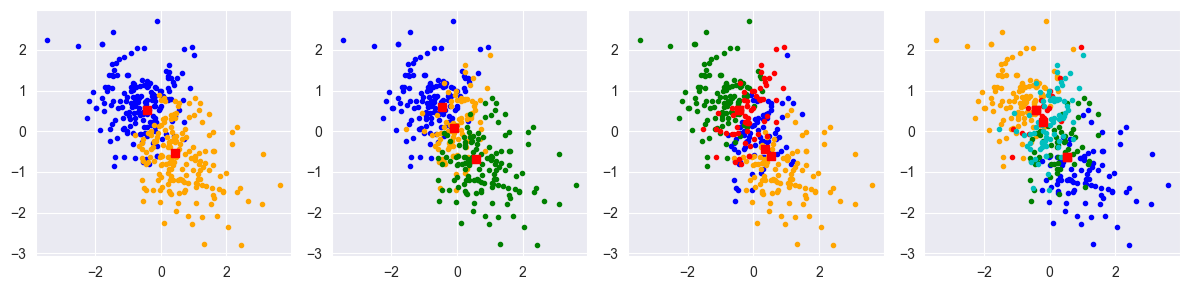

In [328]:
# Get data as numpy array
alldata = df.values.T

# Set up the loop and plot
fig1, axes1 = plt.subplots(1, 4, figsize=(12, 3))

# Prepare colors
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

for ncenters, ax in enumerate(axes1.reshape(-1), 2):

    # Init centers
    u0 = []
    for j in range(alldata.shape[1]):
        # Get a random array of numbers between 0 and 1 that sum to 1
        center = np.random.rand(ncenters)
        center /= np.sum(center)  # Corrected line
        u0.append(center)
    u0 = np.array(u0).T

    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(alldata, ncenters, 2, error=0.005, maxiter=1000, init=u0)

    # Plot assigned clusters, for each data point in training set
    cluster_center = np.argmax(u, axis=0)
    for j in range(ncenters):
        # Plot over ADJOE and ADJDE giving colors[j] to data such that their cluster_center == j
        ax.plot(df['ADJOE'][cluster_center == j], df['ADJDE'][cluster_center == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], -pt[1], 'rs')

fig1.tight_layout()
